In [154]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,Embedding,LSTM
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.initializers import Constant
from keras.regularizers import l2

In [155]:
# Importing IMDB movie reviews dataset
movie_reviews=pd.read_csv('a1_IMDB_Dataset.csv')

In [156]:
# Dataset exploration
movie_reviews.shape

(50000, 2)

In [157]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [158]:
# Checking for missing values
movie_reviews.isnull().values.any()

False

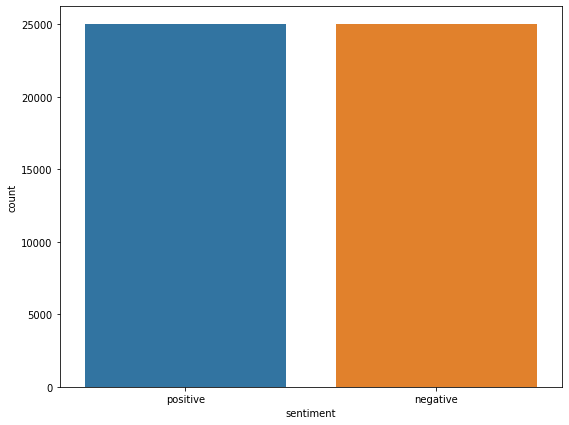

In [159]:
# Let's observe distribution of positive/negative sentiments in dataset
plt.figure(figsize=(9,7))
sns.countplot(data=movie_reviews,x='sentiment')
plt.show()

In [160]:
movie_reviews['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [161]:
TAG_RE=re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replace anything between opening and closing <> with empty space'''
    
    return TAG_RE.sub('',text)

In [162]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\power\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [163]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stopwords composed of A-Z & a-z only in lowercase'''
    
    sentence=sen.lower()
    # Remove html tags
    sentence=remove_tags(sentence)
    # Remove punctuations and numbers
    sentence=re.sub('[^a-zA-Z]',' ',sentence)
    # Single character removal
    sentence=re.sub(r'\s+[a-zA-Z]\s+',' ',sentence)
    # Remove multiple spaces
    sentence=re.sub(r'\s+',' ',sentence)
    # Remove stopwords
    pattern=re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence=pattern.sub('',sentence)
    
    return sentence

In [164]:
# Calling preprocessing_text function on movie_reviews
X=[]
sentence=list(movie_reviews['review'])
for sen in sentence:
    X.append(preprocess_text(sen))

In [165]:
# Sample cleaned up movie review
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [166]:
# Converting sentiment labels to 0 & 1
y=movie_reviews['sentiment']
y=np.array(list(map(lambda x:1 if x=='positive' else 0,y)))

In [167]:
# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [168]:
# Preparing embedding layer
word_tokenizer=tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train=word_tokenizer.texts_to_sequences(X_train)
X_test=word_tokenizer.texts_to_sequences(X_test)

In [169]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings eexist
vocab_length=len(word_tokenizer.word_index)+1
vocab_length

91882

In [170]:
# Padding all reviews to fixed length 100
maxlen=100
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)

In [171]:
# Load GloVe word embeddings and create an Embeddings Dictionary
embedding_dictionary=dict()
glove_file=open('glove.6B.100d.txt',encoding='utf8')
for line in glove_file:
    records=line.split()
    word=records[0]
    vector_dimensions=np.asarray(records[1:],dtype='float32')
    embedding_dictionary[word]=vector_dimensions
glove_file.close()

In [172]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus
embedding_matrix=np.zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
    embedding_vector=embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

In [173]:
lstm_model=Sequential()
embedding_layer=Embedding(vocab_length,100,embeddings_initializer=Constant(embedding_matrix),trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(10))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1,activation='sigmoid'))

In [174]:
lstm_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [175]:
history=lstm_model.fit(X_train,y_train,epochs=3)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 199s 132ms/step - accuracy: 0.6402 - loss: 0.6312
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 166s 133ms/step - accuracy: 0.8261 - loss: 0.4391
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.8991 - loss: 0.2939


In [176]:
score=lstm_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8521 - loss: 0.3987
